---
title: "Understanding Bayesian Thinking for Industrial Applications"
date: 2025-10-10
description: "Learn how Bayesian thinking can enhance decision-making in industrial applications. This article lay the foundation of bayesion modelling with Pymc and their practical use cases."

image: posterior_sensitivity.svg
twitter-card: 
    image: "posterior_sensitivity.svg"
open-graph: 
    image: "posterior_sensitivity.svg"

# Enable banner style title blocks
title-block-banner: true

categories:
  - python
  - bayesian

title-block-banner: "bayesion-01.jpg"
format:
  html:
    code-fold: true
    code-summary: "Show the code"
    code-overflow: wrap
    toc: true
    toc-depth: 2
    reference-location: margin
    quarto-template-params:
      banner-header-class: "blog-post"
---

## Introduction



Suppose your company just installed a new, expensive machine. A critical question arises: *How long will it last before failure?*. The lead engineer, based on experience with previous models, estimates a lifespan of 10 years. However, you only have 3 months of real-world test data for this specific unit. A major warranty and service contract decision needs to be made now.

Traditional (**Frequentist**) Statistics often requires large datasets (the "long run") to make confident statements. In industry, this approach often falls short because we frequently face:

1. Small Samples: Data sparsity with new products, machines, or processes. 

2. Wasted Knowledge: Vast prior expertise (like the engineer's 10-year estimate) that is ignored by the statistical model.

**The Power of the Bayesian Approach**: Bayesian modeling is a framework that allows us to formally incorporate this prior expertise and update it precisely and mathematically as new evidence (data) arrives. It helps us make the best possible decision even under high uncertainty. This shift from ignoring prior knowledge to integrating it is the core of Bayesian thinking.



**What Bayesian Thinking is About**
Traditional (Frequentist) statistics asks: If the true parameter were $\theta$ how likely is the data we observed? 

Bayesian inference asks: Given the data I observed, how likely is each possible value of $\theta$?

This shift—from reasoning about data given a parameter to parameter given data is what makes Bayesian methods so intuitive for decision-making.

The Bayesian approach is learning from data: it is updating our beliefs as new evidence comes in. As such bayesion thinking view probability as a measure of uncertainty about the world, not just a long-run frequency of events (Frequentist View). This perspective is especially useful in industrial contexts where decisions often need to be made with limited data and high uncertainty.

## The Building Blocks of Bayesian modeling

The process of updating our beliefs is formalized by Bayes' Theorem.
$$
P(\theta \mid D) = \frac{P(D \mid \theta) P(\theta)}{P(D)}
$$

While the formula looks mathematical, its components represent a beautifully intuitive learning cycle.

$$ 
\mathrm{Posterior} \propto \mathrm{Likelihood} \times \mathrm{Prior}
$$

Let us break down how this relates to our machine failure problem; ($\theta$ is the machine's expected failure rate, and $D$ is the 3 months of test data)

Thus **Prior** $ P(\theta) $ represents the initial belief **before** seeing data. This is where we inject domain expertise and historical knowledge. For insatnce the engineer's historical estimate that the lifespan is ≈10 years (a low failure rate). This is our starting belief about $\theta$. 

There are different types of priors:
1. **Informative Priors**: Based on strong domain expertise or historical data (e.g., We know with high confidence similar machines have lasted 8-12 years).

2. **Weakly Informative Priors**: Gently guide the model without overwhelming the data (often a good default).

3. **Flat (Uninformative) Priors**: Essentially says, "I have no idea," letting the data completely "speak for itself." This often defeats the purpose of Bayesian modeling in low-data industrial settings.



The **Likelihood**  $P(D \mid \theta)$  is the mathematical tool that connects the observed data to your parameter. It asks: How probable are the observed data, given a specific value of failure rate $\theta$?. Considering our machine example, the likelihood  tell us how likely is it that we saw zero failures in the first 3 months if the true average lifespan was, say, 5 years? Or 15 years? The likelihood measures the evidence provided by your data.


Finally the  **Posterior**  $ P(\theta \mid D) $  is the updated belief after seeing the data. It is the complete answer that incorporates the weight of both your prior knowledge and the new evidence. Considering our machine example, the posterior tells us The new, combined estimate of the expected machine lifespan after factoring in both the engineer's 10-year estimate and the 3 months of failure-free test data.



### PyMC: The Probabilistic Programming Engine
Understanding the relationship $\mathrm{Posterior} \propto \mathrm{Likelihood} \times \mathrm{Prior}$ is the conceptual heart of Bayesian analysis. However, calculating the actual posterior distribution, $ P(\theta \mid D) $, often involves complex, multi-dimensional integration that is impossible to solve analytically for real-world industrial problems. This is where Probabilistic Programming Languages (PPLs) like PyMC become indispensable.

[PyMC]() is an open-source Python library designed to construct and fit Bayesian statistical models using state-of-the-art computational methods. PyMC is not the only powerful PPL in Python. Two other notable options are [pyro]() and [TensorFlow Probability (TFP)](). For this lesson we will stick with pymc

## Case study 1: AB Testing with Small Samples

To shift from theory to practical implementation, we will apply the Bayesian building blocks Prior, Likelihood, and Posterior to a concrete industrial problem common in tech and e-commerce: A/B Testing

> Suppose you are a data scientist at an e-commerce company. The marketing team just launched a new website feature and wants to know:

 1. What's the true conversion rate?

 2. Is it better than the old version (which historically has an 8% conversion rate)?

 3. How much should we trust this estimate with limited data?

> During the first few days of the feature launch, the company has observed 200 visitors with only 15 conversion.



In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import altair as alt
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import numpy as np
from IPython.display import clear_output
import scipy.stats as stats
from great_tables import GT, html, md, px
import math

In [2]:
# Configure Altair for optimal performance
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('default')


np.random.seed(42)

# A/B Test Parameters
visitors = 200
conversions = 15
observed_conversion_rate = conversions / visitors
historical_baseline = 0.08


##### Define Prior, likelihood, and Posterior in PyMC

To model this problem in PyMC, we need to define the Prior and  Likelihood distributions.

**Prior**: For this problem, we are estimating a proportion (the conversion rate $\theta$), which can only range between 0 and 1. The Beta distribution is ideal for modeling parameters that are bounded between 0 and 1, such as probabilities or rates.

The Beta distribution is controlled by two parameters, $\alpha$ and $\beta$. We set these parameters to formally encode our prior knowledge: the historical 8% conversion rate. The mean of a $\mathrm{Beta}(\alpha,\beta)$ distribution is $\frac{\alpha}{ \alpha + \beta}$. Since our historical rate is 8% (or 0.08), we need to choose $\alpha$ and $\beta$ such that:
$$
\frac{\alpha}{ \alpha + \beta} = 0.08
$$

To determine the strength of this belief, we choose a number that represents the effective sample size (ESS) of our historical knowledge. If we choose a hypothetical ESS of 100 trials:

- $\alpha$ (hypothetical successes) $=100×0.08=8$
- $\beta$ (hypothetical failures) $=100−8=92$

**Likelihood** the Likelihood is determined by the process that generated the data. Since we have a fixed number of trials (N=200 visitors) and count the number of successes (k=15 conversions), this is a Binomial distribution.

This small block of code defines and runs our entire Bayesian analysis. For those seeing PyMC for the first time, here is what each section is doing:

1.  `with pm.Model() as model:` This block acts as a container for all the random variables and data in our model. Everything inside this context belongs to the conversion_model
2. `conversion_rate = pm.Beta(...)`: We are telling PyMC that the true conversion_rate is a random variable, and our initial belief is described by the Beta(8,92) distribution.
3. `likelihood = pm.Binomial(...)`: This defines the process that generated our observed data. We link the conversion_rate parameter to the actual observed data (n=visitors, observed=conversions) using the appropriate Binomial distribution.
4. `pm.sample(...)`: This is where the magic happens! The pm.sample function runs the MCMC sampler (the computational engine) to combine the Prior and the Likelihood, effectively calculating the Posterior distribution. We ask the sampler to draw 2000 samples after a 1000-sample tuning period, running 4 independent chains to ensure reliable results.

In [3]:
with pm.Model() as conversion_model:
    # Prior distribution based on historical performance
    conversion_rate = pm.Beta("conversion_rate", alpha=8, beta=92)
    
    # Likelihood function
    likelihood = pm.Binomial("observations", n=visitors, p=conversion_rate, observed=conversions)
    
    # Sample from posterior distribution
    trace = pm.sample(2000, tune=1000, chains=4, random_seed=42, return_inferencedata=True)

clear_output()

## Model Diagnostics

Running `pm.sample()` generates the raw output, but the job isn't done yet. Before we trust the results, we must perform Model Diagnostics to ensure our computational engine (the MCMC sampler) has worked correctly. The single most important diagnostic check is confirming Convergence.

#### Model Convergencevergence 

In Bayesian inference, we use Markov Chain Monte Carlo (MCMC) methods to sample from the complex posterior distribution. We rely on these samples to accurately estimate quantities like the mean conversion rate or its credible interval.

Convergence is the guarantee that the MCMC chains have explored the entire distribution and are now producing samples that truly represent the target Posterior distribution, and are not just stuck in a starting location.

   > **Analogy**: Imagine trying to understand the shape of a deep, misty valley (the posterior). If your chains haven't converged, they might be stuck high up on a ridge, missing the true, deep center. Diagnostics are the tools we use to confirm the chains have found and are walking across the bottom of the true valley.

PyMC uses the supporting library [ArviZ](https://www.arviz.org/en/latest/) for standardizing and analyzing the results, which gives us the following industry-standard diagnostics and plots

1. Trace Plots: Visual inspection of parameter samples across iterations.

    - Good trace plots look like “fuzzy caterpillars” with no trends or jumps.

2. R-hat (Gelman-Rubin Statistic): Measures how well multiple chains agree.

   - R-hat ≈ 1 means convergence.
   - R-hat > 1.01 suggests problems.

3. Effective Sample Size (ESS): Indicates how many independent samples you effectively have.

    - Low ESS means poor mixing or autocorrelation. Good ESS is typically > 200 per parameter.

The most efficient way to check convergence numerically is using the ArviZ summary function, specifically asking for the diagnostics:

```python
az.summary(trace, kind="diagnostics")
```
Alternatively, you can visualize the diagnostics using:

```python
az.plot_trace(trace)

After running the MCMC sampling, for our `conversion_model` we use the az.summary(trace, kind="diagnostics") function to check our chains

In [19]:
diag_table=az.summary(trace, kind="diagnostics")[['ess_bulk', 'ess_tail', 'r_hat']]
GT(diag_table).tab_header(
    title="MCMC Diagnostics",
    subtitle="Conversion Rate Model"
).cols_label({
        'ess_bulk': 'ESS Bulk',
        'ess_tail': 'ESS Tail.',
        'r_hat': 'R-hat',
    })

GT(_tbl_data=                 ess_bulk  ess_tail  r_hat
conversion_rate    3966.0    5559.0    1.0, _body=<great_tables._gt_data.Body object at 0x1655a4790>, _boxhead=Boxhead([ColInfo(var='ess_bulk', type=<ColInfoTypeEnum.default: 1>, column_label='ESS Bulk', column_align='right', column_width=None), ColInfo(var='ess_tail', type=<ColInfoTypeEnum.default: 1>, column_label='ESS Tail.', column_align='right', column_width=None), ColInfo(var='r_hat', type=<ColInfoTypeEnum.default: 1>, column_label='R-hat', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x165ed3730>, _spanners=Spanners([]), _heading=Heading(title='MCMC Diagnostics', subtitle='Conversion Rate Model', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x1655a49a0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='center'), heading_title_font_size=OptionsInfo(scss=True, category='heading', type='px', value='125%'), heading_title_font_weight=OptionsInfo(scss=True, category='heading', type='value', value='initial'), heading_subtitle_font_si

This table immediately tells us the model is reliable and ready for analysis:


- (R_hat = 1.0,Goal Achieved): Since R_hat is exactly 1.0, this confirms that the four independent MCMC chains have fully converged and agree on the shape of the posterior distribution. The model is reliable.

- ESS bulk ​and ESS tail (3966.0 and 5559.0, Goal Achieved): Both effective sample sizes are significantly greater than our >=400 minimum threshold. This means we have plenty of high-quality, effectively independent samples to accurately estimate the mean, mode, and credible intervals of the true conversion rate

##### Visual Check: Trace Plots
While the numbers in the summary table are essential, visually inspecting the MCMC chains confirms the story. We use `az.plot_trace(trace)`

In [5]:
import matplotlib

def set_matplolib_theme():
    from cycler import cycler
    nice_fonts = {
        "font.family": "serif",
        "savefig.bbox" : "tight",
        "savefig.pad_inches" : 0.05,
        "ytick.right" : True,
        "font.serif" : "Times New Roman",
        "mathtext.fontset" : "dejavuserif",
        "axes.labelsize": 15,
        "font.size": 15,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "axes.linewidth" : 0.5,
        "grid.linewidth" : 0.5,
        "lines.linewidth" : 1.,
        "legend.frameon" :False,
        'axes.prop_cycle': cycler(color=['#107591','#f69a48','#00c0bf', '#fdcd49','#8da798','#a19368','#525252','#a6761d','#7035b7','#cf166e'])
         }
    matplotlib.rcParams.update(nice_fonts)

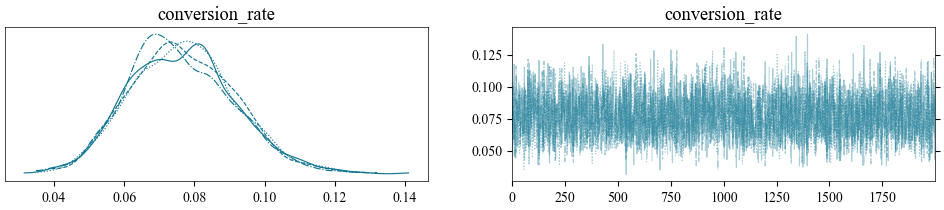

In [6]:
set_matplolib_theme()
az.plot_trace(trace);

The trace plot above shows excellent convergence for our conversion rate ($\theta$) model, supporting the conclusions from our quantitative diagnostics. The plot is split into two panels
1. Right Panel: MCMC Sampling Behavior
    
   - This panel shows the raw sampled values across iterations for each of our four chains. The sampled values oscillate stably around ∼0.075 (7.5%) without any noticeable trends, sudden jumps, or long-term drifts. 
   - The different  lines (chains) are thoroughly intertwined and overlap completely. This "fuzzy caterpillar" appearance is the visual proof that the sampler is efficiently exploring the parameter space and that all chains have converged to the same distribution. 
   - The stable behavior confirms the chain has reached **stationarity**, meaning it is now sampling from the true, converged Posterior distribution.
2. Left Panel: Posterior Distribution

    - This panel shows the estimated Posterior probability density function (PDF) based on the samples taken. The shape is smooth and has a single peak, indicating a well-behaved posterior without multiple ambiguous peaks.
    - The peak is clearly centered at a value close to our observed rate (7.5%), which is what we expect when combining a prior (8%) and data (7.5%).
    - The spread of the distribution clearly visualizes our remaining uncertainty about the true conversion rate.



## Posterior Predictive Checks

We just established that our MCMC sampler for the convernsation_rate model worked perfectly: the R-hat is 1.0, the ESS is high, and the trace plots look like textbook "fuzzy caterpillars." This means our computation is reliable we have accurately found the true, converged posterior distribution.

However, a converged model is not necessarily a good model. We now move to the impotant test: Does our model actually make sense given the data we observed?

This moves us from confirming the sampler to validating the model itself, using Posterior Predictive Checks (PPCs).

> PPCs evaluate model fit by comparing the observed data to simulated data from the posterior distribution. If your model accurately represents the data-generating process, the simulated data should resemble the actual observations.

To achive this it is important to generate new, simulated data from the posterior distribution and compare it to the actual observed data. This is done using the `pm.sample_posterior_predictive` function in PyMC.

In [7]:
with conversion_model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)
    
clear_output()

In [13]:
ppc_summary = az.summary(ppc, kind='stats', hdi_prob=0.95)
ppc_table = (
    GT(ppc_summary)
    .cols_label({
        'mean': 'Mean',
        'sd': 'Std-Dev.',
        'hdi_2.5%': 'HDI 3%',
        'hdi_97.5%': 'HDI 97%'
    }).tab_header(
        title="Posterior Predictive Summary Statistics",
        subtitle=""
    )
)
ppc_table 


GT(_tbl_data=                mean     sd  hdi_2.5%  hdi_97.5%
observations  15.314  4.806       6.0       24.0, _body=<great_tables._gt_data.Body object at 0x165ef2830>, _boxhead=Boxhead([ColInfo(var='mean', type=<ColInfoTypeEnum.default: 1>, column_label='Mean', column_align='right', column_width=None), ColInfo(var='sd', type=<ColInfoTypeEnum.default: 1>, column_label='Std-Dev.', column_align='right', column_width=None), ColInfo(var='hdi_2.5%', type=<ColInfoTypeEnum.default: 1>, column_label='HDI 3%', column_align='right', column_width=None), ColInfo(var='hdi_97.5%', type=<ColInfoTypeEnum.default: 1>, column_label='HDI 97%', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x165ef3dc0>, _spanners=Spanners([]), _heading=Heading(title='Posterior Predictive Summary Statistics', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x165ef2200>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='center'), heading_title_font_size=OptionsInfo(scss=True, category='heading', type='px', value='125%

It clear that the predicted mean (15.314) is extremely close to the actual observed count (15). This is a strong indication that the `conversion_rate model` fits the data very well. And thus the choice of the Beta Prior and Binomial Likelihood is appropriate for this data. The model predicts that 95% of the time, the number of conversions will fall between 6 and 24. Since the company observed value of 15 falls well within this 95% HDI, the actual observation is considered highly plausible according to your model.

In [20]:
ppc_samples = ppc.posterior_predictive['observations'].values.flatten()
percentile = (ppc_samples <= conversions).mean() * 100
print(f"Observed convervation ({conversions}) is at the {percentile:.1f}th percentile of predictions")

Observed convervation (15) is at the 53.7th percentile of predictions


Since your value of 53.7
 is very close to the ideal 50
, this provides further strong evidence (in addition to the mean of 15.314 you already saw) that:

Your model is not biased (it's not systematically over- or under-estimating the data).

Your choice of the Beta-Binomial model is highly appropriate for this data set.

### Model Utility and Business Decision

Having confirmed the reliability of our Bayesian model through the Posterior Predictive Check (PPC), our focus now shifts from "Does the model fit the data?" to the commercially critical question: "Is the model useful for making business decisions?"

Specifically, we utilize the derived posterior distribution to quantify the evidence that the new feature's conversion rate (Feature B) is superior to the existing, established conversion rate (Feature A, which has a known baseline rate of 0.08).

To achieve this, we need to extract the posterior distribution for the conversion_rate parameter that your model estimated.

In [51]:
posterior_samples = trace.posterior.stack(sample=("chain", "draw"))
conversion_samples=posterior_samples['conversion_rate'].values

Then calculate the probability of superiority" - the probability that the new feature (B) is better than the old (A). 

Finally, we can compute the expected uplift in conversion rate and translate that into business value. This involves calculating the difference between the posterior mean conversion rate and the historical rate, then multiplying by the number of visitors and average revenue per conversion.

- 0.95: Strong Evidence. The new feature is very likely superior. You should consider launching it.
- 0.80 Moderate Evidence. The new feature is likely better, but there is still a 20
chance it's worse. Your decision depends on company risk tolerance.
- 0.50 No Evidence. The new feature is a toss-up; there is no statistical reason to prefer it over the old feature.

In [49]:
prob_superiority = (conversion_samples > historical_baseline).mean()
# Display the result
print(f"The probability that the new feature is better than the old rate (0.08) is: {prob_superiority:.3f}")

The probability that the new feature is better than the old rate (0.08) is: 0.397


The calculated Probability of Superiority is approximately 0.40, indicating that there is a 40% chance that the new feature's conversion rate is better than the old feature's 8% rate. There is a 60.3% chance the new feature is worse than the baseline. Since the probability that the new feature is superior is well below the neutral benchmark of 50%, we conclude that the data does not support replacing the existing feature A with the new feature B based on conversion rate alone. The new feature is highly likely to perform worse.

#### Probability of Meaningful Improvement.
Depending on your business context, you might also want to calculate the probability that the new feature is better by a meaningful margin (e.g., >1% improvement).  This calculates the chance that the new feature is better than the old feature by a practically significant margin of at least 1 percentage point. This is a crucial business metric. Sometimes a tiny statistical "win" isn't worth the cost of development and deployment. If this probability is low, it confirms the feature is not a major improvement.


In [56]:
prob_1pct_improvement = (conversion_samples > historical_baseline+0.01).mean()
print(f" Probability of >1% improvement: {prob_1pct_improvement:.1%}")

 Probability of >1% improvement: 18.4%


#### Probability of Hitting a Target Rate

This calculates the chance that the true conversion rate of the new feature 
is 10% or higher. This is useful if 10% is a specific, ambitious KPI (Key Performance Indicator) or goal set by the marketing or product team. It tells them how likely they are to meet their goal.

In [57]:
prob_10pct = (conversion_samples > 0.10).mean()
print(f" Probability of >10% improvement: {prob_10pct:.1%}")

 Probability of >10% improvement: 6.3%


#### Expected Value of the Change.
This is the single-number best estimate of the average change (positive or negative) you can expect to see if you deploy the new feature. This is the foundation for the "Expected Business Impact" section. If this value is negative, it represents an Expected Loss. If you calculate: expected_uplift * Total Visitors * ARPC, you get the estimated dollar value of the change.

In [59]:
# Calculate key business probabilities
expected_uplift = conversion_samples.mean() - historical_baseline

# Calculate expected business impact
monthly_visitors = 10000
expected_additional_conversions = monthly_visitors * expected_uplift
conversion_value = 50  # Average value per conversion
expected_monthly_value = expected_additional_conversions * conversion_value

print(f"Expected uplift: {expected_uplift:.4f} ({expected_uplift:.2%} points)")
print(f"Expected monthly value: ${expected_monthly_value:,.0f}")


Expected uplift: -0.0034 (-0.34% points)
Expected monthly value: $-1,717


The implication is that if you deploy the new feature, you expect to lose 30 conversions per month, resulting in an Expected Monthly Loss of $1,500 for your business. This financial quantification is the most compelling reason to reject the new feature (unless, of course, the feature offers unquantified benefits that are worth more than $1,500)

## Prior Predictive Checks: Validating Model Assumptions

While the previous section's Posterior Predictive Check (PPC) demonstrated that our fitted model is reliable by successfully reproducing the observed data, a complete Bayesian analysis requires us to first validate the assumptions we made before seeing any data.

This validation is accomplished through the Prior Predictive Check.

> Prior Predictive Checks  are a crucial step in the Bayesian workflow that helps validate your prior assumptions before you fit the model to data. Unlike posterior predictive checks that evaluate model fit after seeing the data, prior PPCs show what kind of data your model expects to generate based solely on your prior beliefs.

In [65]:
# Test different prior beliefs
priors_to_test = [
    ("Very Optimistic", 15, 85),    # Believes 15% conversion rate
    ("Optimistic", 12, 88),         # Believes 12% conversion rate  
    ("Historical Based", 8, 92),    # Our original prior (8%)
    ("Skeptical", 4, 96),           # Believes 4% conversion rate
    ("Very Skeptical", 2, 98),      # Believes 2% conversion rate
    ("Uninformative", 1, 1),        # Let data dominate completely
]

sensitivity_results = []

for prior_name, alpha, beta in priors_to_test:
    with pm.Model() as model:
        conversion_rate = pm.Beta("conversion_rate", alpha=alpha, beta=beta)
        obs = pm.Binomial("observations", n=visitors, p=conversion_rate, observed=conversions)
        trace_temp = pm.sample(1000, tune=500, random_seed=42, progressbar=False)
    
    posterior_mean = trace_temp.posterior["conversion_rate"].mean().values
    posterior_std = trace_temp.posterior["conversion_rate"].std().values
    prob_better = (trace_temp.posterior["conversion_rate"].values > historical_baseline).mean()
    
    sensitivity_results.append({
        'Prior_Belief': prior_name,
        'Prior_Parameters': f"Beta({alpha}, {beta})",
        'Prior_Mean': f"{alpha/(alpha+beta):.3f}",
        'Posterior_Mean': f"{posterior_mean:.3f}",
        'Posterior_Std': f"{posterior_std:.3f}",
        'Prob_Better': f"{prob_better:.1%}",
        'Data_Influence': 'Strong' if abs(posterior_mean - (alpha/(alpha+beta))) > 0.02 else 'Moderate'
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

# Create sensitivity analysis table
sensitivity_table = (
    GT(sensitivity_df)
    .tab_header(
        title="Sensitivity Analysis: Impact of Prior Beliefs",
        subtitle="How Different Starting Assumptions Affect Final Conclusions"
    )
    .cols_label(
        Prior_Belief="Prior Belief",
        Prior_Parameters="Prior Distribution", 
        Prior_Mean="Prior Mean",
        Posterior_Mean="Posterior Mean",
        Posterior_Std="Posterior Std",
        Prob_Better="Prob. Better",
        Data_Influence="Data Influence"
    )
    .data_color(
        columns=["Prob_Better"],
        palette=["#C73E1D", "#F18F01", "#2E8B57"],
        domain=[0.0, 0.5, 1.0]
    )
    .data_color(
        columns=["Data_Influence"],
        palette=["#2E8B57", "#F18F01", "#C73E1D"],
        domain=["Strong", "Moderate", "Weak"]
    )
    .tab_source_note(
        "Analysis shows robustness of conclusions to different prior assumptions • "
        "Even skeptical priors converge toward data-driven truth"
    )
    .tab_options(
        table_width="100%",
    )
)
clear_output()
sensitivity_table

GT(_tbl_data=       Prior_Belief Prior_Parameters Prior_Mean Posterior_Mean Posterior_Std  \
0   Very Optimistic     Beta(15, 85)      0.150          0.100         0.017   
1        Optimistic     Beta(12, 88)      0.120          0.090         0.016   
2  Historical Based      Beta(8, 92)      0.080          0.077         0.015   
3         Skeptical      Beta(4, 96)      0.040          0.063         0.014   
4    Very Skeptical      Beta(2, 98)      0.020          0.056         0.013   
5     Uninformative       Beta(1, 1)      0.500          0.078         0.019   

  Prob_Better Data_Influence  
0       88.3%         Strong  
1       71.7%         Strong  
2       39.7%       Moderate  
3       12.7%         Strong  
4        4.8%         Strong  
5       43.3%         Strong  , _body=<great_tables._gt_data.Body object at 0x14996de10>, _boxhead=Boxhead([ColInfo(var='Prior_Belief', type=<ColInfoTypeEnum.default: 1>, column_label='Prior Belief', column_align='left', column_width=None), ColInfo(var='Prior_Parameters', type=<ColInfoTypeEnum.default: 1>, column_label='Prior Distribution', column_align='left', column_width=None), ColInfo(var='Prior_Mean', type=<ColInfoTypeEnum.default: 1>, column_label='Prior Mean', column_align='right', column_width=None), ColInfo(var='Posterior_Mean', type=<ColInfoTypeEnum.default: 1>, column_label='Posterior Mean', column_align='right', column_width=None), ColInfo(var='Posterior_Std', type=<ColInfoTypeEnum.default: 1>, column_label='Posterior Std', column_align='right', column_width=None), ColInfo(var='Prob_Better', type=<ColInfoTypeEnum.default: 1>, column_label='Prob. Better', column_align='right', column_width=None), ColInfo(var='Data_Influence', type=<ColInfoTypeEnum.default: 1>, column_label='Data Influence', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x14970b610>, _spanners=Spanners([]), _heading=Heading(title='Sensitivity Analysis: Impact of Prior Beliefs', subtitle='How Different Starting Assumptions Affect Final Conclusions', preheader=None), _stubhead=None, _source_notes=['Analysis shows robustness of conclusions to different prior assumptions • Even skeptical priors converge toward data-driven truth'], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Prob_Better', rows=[0], mask=None), grpname=None, colname='Prob_Better', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#808080')]), StyleInfo(locname=LocBody(columns='Prob_Better', rows=[1], mask=None), grpname=None, colname='Prob_Better', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#808080')]), StyleInfo(locname=LocBody(columns='Prob_Better', rows=[2], mask=None), grpname=None, colname='Prob_Better', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#808080')]), StyleInfo(locname=LocBody(columns='Prob_Better', rows=[3], mask=None), grpname=None, colname='Prob_Better', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#808080')]), StyleInfo(locname=LocBody(columns='Prob_Better', rows=[4], mask=None), grpname=None, colname='Prob_Better', rownum=4, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#808080')]), StyleInfo(locname=LocBody(columns='Prob_Better',